In [124]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, minmax_scale, scale

In [125]:
CPU_CSV = './Data/cpu.csv'
cpu_df = pd.read_csv(CPU_CSV)
print(cpu_df)

    Manufacturer         Name       Codename    Cores           Clock  \
0            AMD     A10-9700  Bristol Ridge        4  3.5 to 3.8 GHz   
1            AMD    A10-9700E  Bristol Ridge        4    3 to 3.5 GHz   
2            AMD     A12-9800  Bristol Ridge        4  3.8 to 4.2 GHz   
3            AMD    A12-9800E  Bristol Ridge        4  3.1 to 3.8 GHz   
4            AMD      A6-9500  Bristol Ridge        2  3.5 to 3.8 GHz   
..           ...          ...            ...      ...             ...   
402        Intel  Xeon W-3323     Ice Lake-W  12 / 24    3.5 to 4 GHz   
403        Intel  Xeon W-3335     Ice Lake-W  16 / 32    3.4 to 4 GHz   
404        Intel  Xeon W-3345     Ice Lake-W  24 / 48      3 to 4 GHz   
405        Intel  Xeon W-3365     Ice Lake-W  32 / 64    2.7 to 4 GHz   
406        Intel  Xeon W-3375     Ice Lake-W  38 / 76    2.5 to 4 GHz   

          Socket Process L3 Cache    TDP        Released  
0     Socket AM4   28 nm      NaN   65 W  Jul 27th, 2017  
1    

In [126]:
def get_boost_clock(string):
    capture = re.findall(r'\d{1}\.*\d*', string)
    if capture:
        aux = capture[-1]
        clock = float(aux)
        if "MHz" in string:
            clock /= 1000
        return clock
    else:
        return None

def get_cores_threads(string):
    capture = re.findall(r'\d+', string)
    if capture:
        if len(capture) > 1:
            return int(capture[0]), int(capture[1])
        else:
            return int(capture[0]), int(capture[0])
    else:
        return None

def get_val(string):
    capture = re.findall(r'\d+', string)
    if capture:
        return int(capture[0])
    else:
        return None

def get_year(string):
    capture = re.findall(r'\d+', string)
    if capture:
        return int(capture[1])
    else:
        return None

In [127]:
# Insert boost clock, cores and threads
clocks = [get_boost_clock(cpu_df.loc[i, 'Clock']) for i in cpu_df.index]
cores = [get_cores_threads(cpu_df.loc[i, 'Cores'])[0] for i in cpu_df.index]
threads = [get_cores_threads(cpu_df.loc[i, 'Cores'])[1] for i in cpu_df.index]
nodes = [get_val(cpu_df.loc[i, 'Process']) for i in cpu_df.index]
watts = [get_val(cpu_df.loc[i, 'TDP']) for i in cpu_df.index]
years = [get_year(cpu_df.loc[i, 'Released']) for i in cpu_df.index]
cpu_df.insert(5, "Boost", clocks)
cpu_df.insert(4, "Threads", threads)
for i in cpu_df.index:
    cpu_df.at[i, 'Cores'] = cores[i]
    cpu_df.at[i, 'Process'] = nodes[i]
    cpu_df.at[i, 'TDP'] = watts[i]

# Remove 2017
cpu_df = cpu_df[~cpu_df.Released.str.contains("2017")]
cpu_df = cpu_df[~cpu_df.Released.str.contains("2018")]

print(cpu_df)

    Manufacturer          Name    Codename Cores  Threads           Clock  \
188          AMD  Athlon 3000G         Zen     2        4         3.5 GHz   
189          AMD    EPYC 7232P        Rome     8       16  3.1 to 3.2 GHz   
190          AMD     EPYC 7252        Rome     8       16  2.8 to 3.2 GHz   
191          AMD     EPYC 7262        Rome     8       16  3.1 to 3.3 GHz   
192          AMD     EPYC 7272        Rome    12       24  2.6 to 3.2 GHz   
..           ...           ...         ...   ...      ...             ...   
402        Intel   Xeon W-3323  Ice Lake-W    12       24    3.5 to 4 GHz   
403        Intel   Xeon W-3335  Ice Lake-W    16       32    3.4 to 4 GHz   
404        Intel   Xeon W-3345  Ice Lake-W    24       48      3 to 4 GHz   
405        Intel   Xeon W-3365  Ice Lake-W    32       64    2.7 to 4 GHz   
406        Intel   Xeon W-3375  Ice Lake-W    38       76    2.5 to 4 GHz   

     Boost       Socket Process L3 Cache  TDP        Released  
188    3.5 

In [128]:
# Drop server CPUs
servers = []
for i in cpu_df.index:
    name = cpu_df.loc[i, "Name"]
    if ("EPYC".lower() in name.lower()) or ("Xeon".lower() in name.lower()):
        servers.append(i)
cpu_df.drop(servers, inplace=True)
cpu_df.reset_index(inplace=True, drop=True)

print(cpu_df)

    Manufacturer                Name      Codename Cores  Threads  \
0            AMD        Athlon 3000G           Zen     2        4   
1            AMD       Ryzen 3 3200G       Picasso     4        4   
2            AMD       Ryzen 5 3400G       Picasso     4        8   
3            AMD       Ryzen 5 3500X       Matisse     6        6   
4            AMD        Ryzen 5 3600       Matisse     6       12   
..           ...                 ...           ...   ...      ...   
122        Intel     Core i9-11900KF   Rocket Lake     8       16   
123        Intel      Core i9-11900T   Rocket Lake     8       16   
124        Intel      Core i9-12900K    Alder Lake    16       24   
125        Intel     Core i9-12900KF    Alder Lake    16       24   
126        Intel  Pentium Gold G6605  Comet Lake-R     2        4   

              Clock  Boost       Socket Process L3 Cache  TDP        Released  
0           3.5 GHz    3.5   Socket AM4      14      4MB   35  Nov 20th, 2019  
1      3.6 

In [129]:
perf = []
for i in cpu_df.index:
    if cpu_df.at[i, 'Codename'] == "Alder Lake":
        k = 0.95
    else:
        k = 1
    perf.append(cpu_df.at[i, 'Threads'] * k * cpu_df.at[i, 'Boost'])

cpu_df.insert(12, "Performance", perf)
print(cpu_df)

    Manufacturer                Name      Codename Cores  Threads  \
0            AMD        Athlon 3000G           Zen     2        4   
1            AMD       Ryzen 3 3200G       Picasso     4        4   
2            AMD       Ryzen 5 3400G       Picasso     4        8   
3            AMD       Ryzen 5 3500X       Matisse     6        6   
4            AMD        Ryzen 5 3600       Matisse     6       12   
..           ...                 ...           ...   ...      ...   
122        Intel     Core i9-11900KF   Rocket Lake     8       16   
123        Intel      Core i9-11900T   Rocket Lake     8       16   
124        Intel      Core i9-12900K    Alder Lake    16       24   
125        Intel     Core i9-12900KF    Alder Lake    16       24   
126        Intel  Pentium Gold G6605  Comet Lake-R     2        4   

              Clock  Boost       Socket Process L3 Cache  TDP        Released  \
0           3.5 GHz    3.5   Socket AM4      14      4MB   35  Nov 20th, 2019   
1      3.

In [130]:
# Drop irrelevant features
cpu_df.drop(['Codename', 'Cores', 'Threads', 'Clock', 'Boost', 'Process', 'L3 Cache', 'Released'], axis=1, inplace=True)

print(cpu_df)

    Manufacturer                Name       Socket  TDP  Performance
0            AMD        Athlon 3000G   Socket AM4   35        14.00
1            AMD       Ryzen 3 3200G   Socket AM4   65        16.00
2            AMD       Ryzen 5 3400G   Socket AM4   65        33.60
3            AMD       Ryzen 5 3500X   Socket AM4   65        24.60
4            AMD        Ryzen 5 3600   Socket AM4   65        50.40
..           ...                 ...          ...  ...          ...
122        Intel     Core i9-11900KF  Socket 1200  125        84.80
123        Intel      Core i9-11900T  Socket 1200   35        78.40
124        Intel      Core i9-12900K  Socket 1700  125       118.56
125        Intel     Core i9-12900KF  Socket 1700  125       118.56
126        Intel  Pentium Gold G6605  Socket 1200   65        17.20

[127 rows x 5 columns]


<AxesSubplot:>

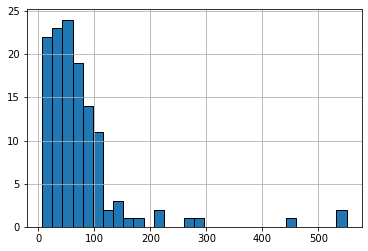

In [131]:
cpu_df['Performance'].hist(bins=30, edgecolor='k')

In [132]:
perf_labels = pd.qcut(cpu_df["Performance"], 3, labels=["light", "moderate", "high"])
for i in cpu_df.index:
    cpu_df.loc[i, "Performance"] = perf_labels[i]

print(cpu_df)

    Manufacturer                Name       Socket  TDP Performance
0            AMD        Athlon 3000G   Socket AM4   35       light
1            AMD       Ryzen 3 3200G   Socket AM4   65       light
2            AMD       Ryzen 5 3400G   Socket AM4   65       light
3            AMD       Ryzen 5 3500X   Socket AM4   65       light
4            AMD        Ryzen 5 3600   Socket AM4   65    moderate
..           ...                 ...          ...  ...         ...
122        Intel     Core i9-11900KF  Socket 1200  125        high
123        Intel      Core i9-11900T  Socket 1200   35        high
124        Intel      Core i9-12900K  Socket 1700  125        high
125        Intel     Core i9-12900KF  Socket 1700  125        high
126        Intel  Pentium Gold G6605  Socket 1200   65       light

[127 rows x 5 columns]


In [133]:
CLEAN_CPU_CSV = "./Data/cpu_clean.csv"
cpu_df.to_csv(CLEAN_CPU_CSV, index=False)